In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
%matplotlib qt

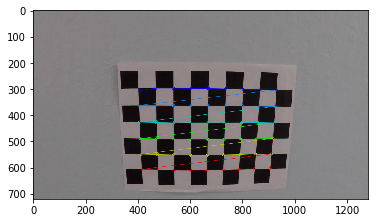

In [5]:
%matplotlib inline
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx = 9
ny = 6
objpoints = []
imgpoints = []
# Generate object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates
# Make a list of calibration images

images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in (images):
    img=cv2.imread(fname)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If corners present
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        img=cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.imshow(img)
        cv2.imwrite('output_images/ChessCorners.jpg', img)
plt.imshow(img)

Text(0.5,1,'Undistorted Image')

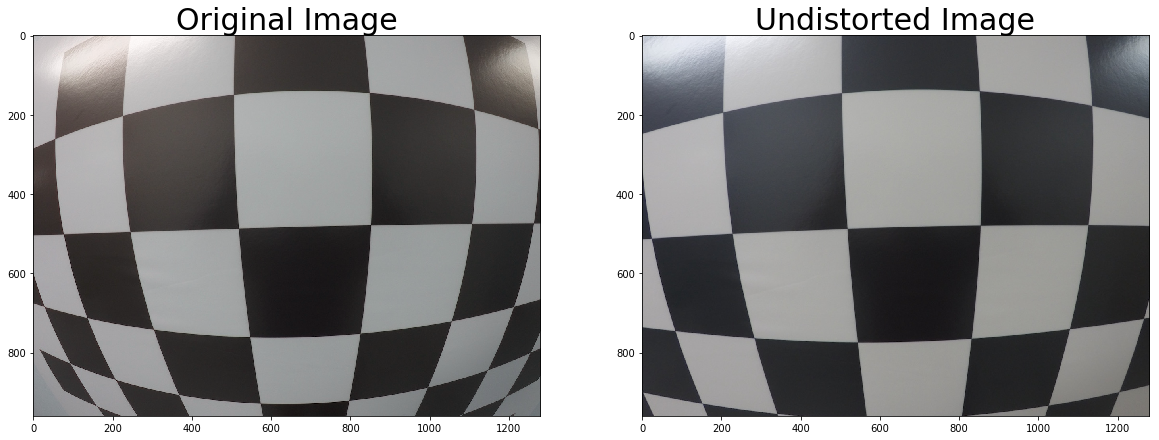

In [6]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('test_image.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#img_size = (img.shape[1], img.shape[0])
img_size = (gray.shape[1], gray.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
undst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist_result.jpg',undst)
undst = cv2.cvtColor(undst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undst)
ax2.set_title('Undistorted Image', fontsize=30)

### Save the image calibration results mtx and dist as pickle file
The camera matrix and distortion matrix will be useful to calibrate camera images in coming examples. Hence, it is stored in a pickle file for later use in the main folder with the name **wide_dist_pickle.p**.

In [7]:
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

### Let us try to undistort a test image
The above algorithm is tested on **test1.jpg** given in the **test_images** folder
The result is stored as **test1_undist_result.jpg** in **output_images** folder. The result can also be viewed below.

Text(0.5,1,'Undistorted Image')

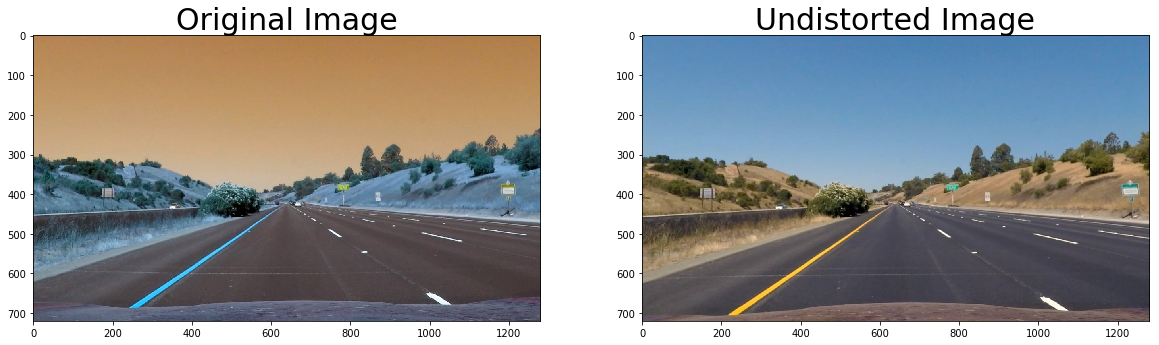

In [8]:
# Test undistortion on an image
img = cv2.imread('test_images/straight_lines1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#img_size = (img.shape[1], img.shape[0])
img_size = (gray.shape[1], gray.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
undst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test1_undist_result.jpg',undst)
undst = cv2.cvtColor(undst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undst)
ax2.set_title('Undistorted Image', fontsize=30)

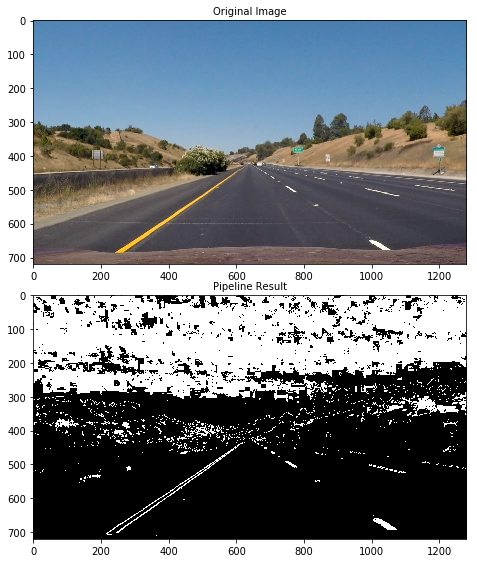

In [30]:
with open("wide_dist_pickle.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]
image = mpimg.imread('test_images/straight_lines1.jpg')
undst = cv2.undistort(image, mtx, dist, None, mtx)
undst = cv2.cvtColor(undst, cv2.COLOR_BGR2RGB)

def sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thresh_min=25
    thresh_max=255
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output



def color_threshold(image, sthresh=(0,255), vthresh=(0,255),bthresh=(0,255)):
    
    #r_channel=image[:,:,0]
    #r_binary=np.zeros_like(r_channel)
    #r_binary[(r_channel > sthresh[0]) & (r_channel <= sthresh[1])] = 1
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    b_channel=lab[:,:,2]
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel > bthresh[0]) & (b_channel <= bthresh[1])] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel > vthresh[0]) & (v_channel <= vthresh[1])] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary == 1)& (b_binary ==1) & (v_binary == 1)] = 1

    # Return the combined s_channel & v_channel binary image
    return output


def threshold_pipeline(img, s_thresh=(90, 255), sx_thresh=(20, 100)):
    gradx = sobel_thresh(undst, orient='x', thresh_min=50, thresh_max=100)
    grady = sobel_thresh(undst, orient='y', thresh_min=50, thresh_max=100)
    c_binary = color_threshold(undst, sthresh=(100,255), vthresh=(50,255),bthresh=(100,200))
    combinedResult = np.zeros_like(undst[:,:,0])
    combinedResult[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255
    return combinedResult
        
combinedResult = threshold_pipeline(image)

#plt.imshow(combinedResult,cmap='gray')
# Plot the result
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=10)

ax2.imshow(combinedResult,cmap='gray')
ax2.set_title('Pipeline Result', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## GOAL 4: Apply a perspective transform to rectify binary image ("birds-eye view")

In [31]:
imshape = image.shape #y,x coordinates
#height = image.shape[0]# offset for dst points
#offset = 50
#offset_height = height - offset
vertices = np.array([[(0,imshape[0]),(600,450), (750, 450), (imshape[1],imshape[0])]], dtype=np.int32)

def region_of_interest(img, vertices):
        mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
    #filling pixels inside the polygon defined by "vertices" with the fill color 
        cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

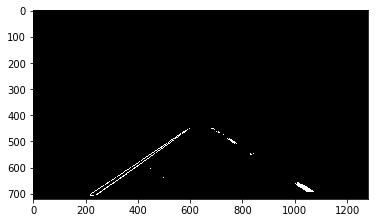

In [32]:
masked_image = region_of_interest(combinedResult, vertices)
plt.imshow(masked_image, cmap="gray")


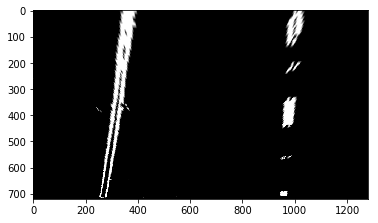

In [33]:
# For source points I'm grabbing the outer four detected corners
src = np.float32(
    [[120, 720],
     [550, 460],
     [700, 460],
     [1160, 720]])
#src=np.float32([[(0,imshape[0]),(600,450), (750, 450), (imshape[1],imshape[0])]])
#dst = np.float32([[200,imshape[1]],[550,400] ,[700,400], [imshape[0]-100,imshape[1]]])
dst = np.float32(
    [[200,720],
     [200,0],
     [1000,0],
     [1000,720]])
#src=np.float32([[offset,imshape[1]-offset],[offset,offset],[imshape[0]-offset,offset],[imshape[0]-offset,imshape[1]-offset]])
#dst = np.float32([[offset, offset], [img_size[0]-offset, offset],[img_size[0]-offset, img_size[1]-offset],[offset, img_size[1]-offset]])
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst, src)
binary_warped = cv2.warpPerspective(combinedResult, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
#imshpe[1],imshape[0] to make it x y
plt.imshow(binary_warped,cmap='gray')

## Detect lane pixels and fit to find the lane boundary

#### Detecting Histogram Peaks

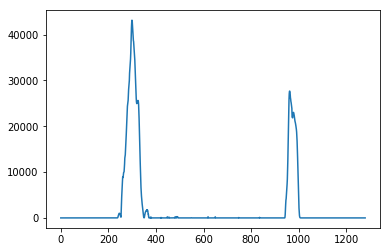

In [34]:
bottom_half = binary_warped[binary_warped.shape[0]//2:,:]
histogram = np.sum(bottom_half, axis=0)
plt.plot(histogram)

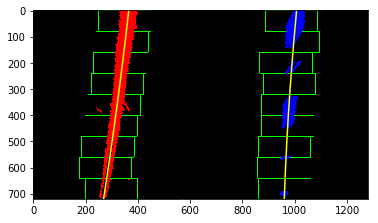

In [35]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fitx, right_fitx, ploty 


out_img, left_fitx, right_fitx, ploty  = fit_polynomial(binary_warped)

plt.imshow(out_img)

In [36]:
y_eval=np.max(ploty)
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
#convert to meters
left_cr_fit=np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix,2)
right_cr_fit=np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix,2)
left_curverad=((1+(2*left_cr_fit[0]*y_eval/2. + left_cr_fit[1])**2)**1.5)/np.absolute(2*left_cr_fit[0])
right_curverad=((1+(2*right_cr_fit[0]*y_eval/2. + right_cr_fit[1])**2)**1.5)/np.absolute(2*right_cr_fit[0])
curverad = (left_curverad + right_curverad) / 2

left_line_pos=(left_fit[0]*719**2)+left_fit[1]*719+left_fit[2] #left_fitx
right_line_pos=(right_fit[0]*719**2)+right_fit[1]*719+right_fit[2] #right_fitx
mpoint=((right_line_pos-left_line_pos)/2)+left_line_pos
offset=(640-mpoint)*xm_per_pix
print('Camera Offset:',offset)   
print('left Curve:', left_curverad,'meters;', 'Right Curve:',  right_curverad, 'meters')
print ('Radius of Curve:', curverad)

Camera Offset: 0.134726205808
left Curve: 5621.43068459 meters; Right Curve: 3982.71213557 meters
Radius of Curve: 4802.07141008


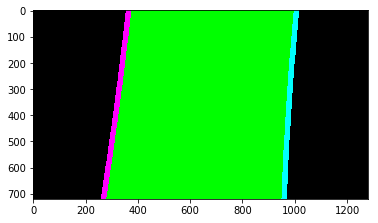

In [37]:
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] ) 
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=20)
cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=20)
plt.imshow(color_warp)

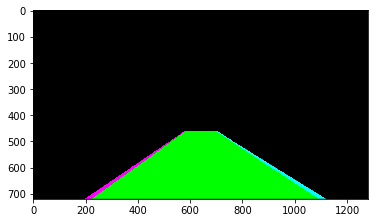

In [38]:
lane_lines = cv2.warpPerspective(color_warp, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(lane_lines)

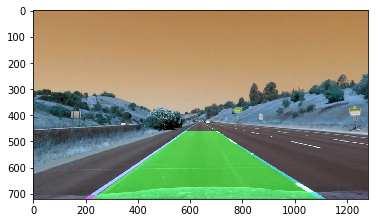

In [39]:
result = cv2.addWeighted(undst, 1, lane_lines, 0.5, 0)
plt.imshow(result)

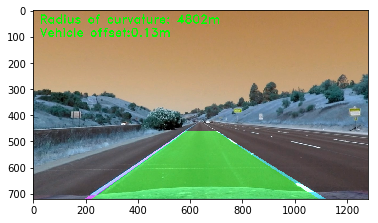

In [40]:
text1 = 'Radius of curvature: ' + '{:04.0f}'.format(curverad) + 'm'
text2 = 'Vehicle offset:'+ '{:03.2f}'.format(offset) + 'm'
cv2.putText(result, text1,(25,50), cv2.FONT_HERSHEY_DUPLEX, 1.5, (0,255, 0), 2, cv2.LINE_AA)
cv2.putText(result, text2,(25,100), cv2.FONT_HERSHEY_DUPLEX, 1.5, (0,255, 0), 2, cv2.LINE_AA)
plt.imshow(result)

## PIPE LINE 

In [41]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
%matplotlib qt

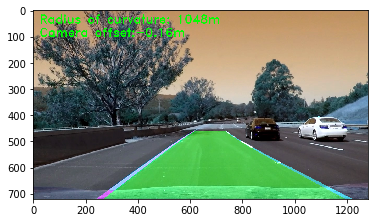

In [49]:
%matplotlib inline
####Define Functions

def sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    thresh_min=25
    thresh_max=255
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 0, 1))
    # Rescale to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

def color_threshold(image, sthresh=(0,255), vthresh=(0,255),bthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    b_channel=lab[:,:,2]
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel > bthresh[0]) & (b_channel <= bthresh[1])] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel > vthresh[0]) & (v_channel <= vthresh[1])] = 1

    c_binary = np.zeros_like(s_channel)
    c_binary[(s_binary == 1)& (b_binary ==1) & (v_binary == 1)] = 1

    return c_binary

def threshold_pipeline(undst):
    gradx = sobel_thresh(undst, orient='x', thresh_min=50, thresh_max=100)
    grady = sobel_thresh(undst, orient='y', thresh_min=50, thresh_max=100)
    c_binary = color_threshold(undst, sthresh=(100,255), vthresh=(50,255),bthresh=(50,255))
    combined_binary = np.zeros_like(undst[:,:,0])
    combined_binary[((gradx == 1) & (grady ==1) | (c_binary == 1))] = 255
   
    return combined_binary

def region_of_interest(img, vertices):
        mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255
    #filling pixels inside the polygon defined by "vertices" with the fill color 
        cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
                        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img
def fit_polynomial(binary_warped, leftx, lefty, rightx, righty, out_img):
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    return out_img, left_fitx, right_fitx, ploty

def pipeline_advanced_lane(img):
    # Test undistortion on an image
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img_size = (gray.shape[1], gray.shape[0])

    # Do camera calibration given object points and image points
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    undst = cv2.cvtColor(undst, cv2.COLOR_BGR2RGB)
     
    combinedResult = threshold_pipeline(undst)
    
    #Region of Interest Pipeline
    masked_image = region_of_interest(combinedResult, vertices)
    
    
    # Perspective Transform
    # For source points I'm grabbing the outer four detected corners
    src = np.float32([[120, 720],[550, 460],[700, 460],[1160, 720]])
    dst = np.float32([[200,720],[200,0],[1000,0],[1000,720]])
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    binary_warped = cv2.warpPerspective(combinedResult, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    #imshpe[1],imshape[0] to make it x y
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)   
    out_img, left_fitx, right_fitx, ploty  = fit_polynomial(binary_warped,leftx, lefty, rightx, righty, out_img)
    
    y_eval=np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_cr_fit=np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix,2)
    right_cr_fit=np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix,2)
    left_curverad=((1+(2*left_cr_fit[0]*y_eval/2. + left_cr_fit[1])**2)**1.5)/np.absolute(2*left_cr_fit[0])
    right_curverad=((1+(2*right_cr_fit[0]*y_eval/2. + right_cr_fit[1])**2)**1.5)/np.absolute(2*right_cr_fit[0])
    curverad = (left_curverad + right_curverad) / 2
    
    left_coeff=(left_fit[0]*719**2)+left_fit[1]*719+left_fit[2]
    right_coeff=(right_fit[0]*719**2)+right_fit[1]*719+right_fit[2]
    mpoint=((right_coeff-left_coeff)/2)+left_coeff
    offset=(640-mpoint)*xm_per_pix
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=20)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=20)
    lane_lines = cv2.warpPerspective(color_warp, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    
    result = cv2.addWeighted(img, 1, lane_lines, 0.5, 0)
    text1 = 'Radius of curvature: ' + '{:04.0f}'.format(curverad) + 'm'
    text2 = 'Camera offset:'+ '{:03.2f}'.format(offset) + 'm'
    cv2.putText(result, text1,(25,50), cv2.FONT_HERSHEY_DUPLEX, 1.5, (0,255, 0), 2, cv2.LINE_AA)
    cv2.putText(result, text2,(25,100), cv2.FONT_HERSHEY_DUPLEX, 1.5, (0,255, 0), 2, cv2.LINE_AA)
  

    return result
  
fname = 'test_images/test6.jpg'
img = cv2.imread(fname)
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
imshape = img.shape #y,x coordinates
vertices = np.array([[(0,imshape[0]),(600,450), (750, 450), (imshape[1],imshape[0])]], dtype=np.int32)
result = pipeline_advanced_lane(img)
plt.imshow(result)

In [23]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [28]:
output = 'project_output_colour.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,30)
#clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(pipeline_advanced_lane) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

#white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
#white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_output_colour.mp4
[MoviePy] Writing video project_output_colour.mp4


100%|█████████▉| 750/751 [03:53<00:00,  3.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_colour.mp4 

CPU times: user 2min 37s, sys: 1.75 s, total: 2min 39s
Wall time: 3min 56s


In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))